## MASK RCNN USING COCO PRE_TRAINED WEIGHTS

In [12]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import skimage.io
import PIL
import PIL.Image
import pathlib
import os
import sys

ROOT_DIR = "/Users/jamesdutfield/Mask_RCNN"
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

In [13]:
def _generate_examples(images_dir_path, annotations_dir_path,
                         images_list_file):
    #with tf.io.gfile.GFile(images_list_file, "r") as images_list:
    with tf.gfile.GFile(images_list_file, "r") as images_list:
      for line in images_list:
        image_name, label, species, _ = line.strip().split(" ")

        trimaps_dir_path = os.path.join(annotations_dir_path, "trimaps")

        trimap_name = image_name + ".png"
        image_name += ".jpg"
        label = int(label) - 1
        species = int(species) - 1

        record = {
            "image": os.path.join(images_dir_path, image_name),
            "label": int(label),
            "species": species,
            "file_name": image_name,
            "segmentation_mask": os.path.join(trimaps_dir_path, trimap_name)
        }
        yield image_name, record

In [14]:
images_dir_path = '/Users/jamesdutfield/opt/anaconda3/lib/python3.7/site-packages/tensorflow_datasets/image_classification/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_imagesZxlcXhwB8atfm2pdIrjCelgNiW7ORYkX5h1Fkzf6MY0.tar.gz/images'
annotations_dir_path = '/Users/jamesdutfield/opt/anaconda3/lib/python3.7/site-packages/tensorflow_datasets/image_classification/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_annotationsUkJftt5cQklCt2JrQoZW_L15jblwqTffYXUMDx01jpE.tar.gz/annotations'
images_list_path = '/Users/jamesdutfield/opt/anaconda3/lib/python3.7/site-packages/tensorflow_datasets/image_classification/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_annotationsUkJftt5cQklCt2JrQoZW_L15jblwqTffYXUMDx01jpE.tar.gz/annotations/trainval.txt'

In [15]:
_generation = _generate_examples(images_dir_path, annotations_dir_path, images_list_path)

In [16]:
class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:
    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...
    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        self.mask_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
        
    def add_mask(self, source, image_id, path, class_id):
        mask_info = {
            "id": image_id,
            "source": source,
            "path": path,
            "class_id": class_id,
        }

        self.mask_info.append(mask_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.
        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        # Mapping from source class and image IDs to internal IDs
        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.
        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        image = self.pad_image(image)
        return image
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        mask = PIL.Image.open(self.mask_info[image_id]['path'])
        mask = np.array(mask)
        mask = self.pad_image(mask, "trimap")
        mask[mask==2]=0
        mask[mask==3]=0
        #mask = np.array(mask,dtype=bool)
        mask.shape=(640,640,1)
        
        class_id = self.mask_info[image_id]['class_id']

        
        class_ids = np.array([class_id], np.int32)
        class_ids.shape=(1,1)
        #class_ids = np.ones([mask.shape[-1]], dtype=np.int32)
        return mask, class_ids
    def pad_image(self,image, d="n"):
    
        if d == 'trimap':
            col=[2,2,2]
        else:
            col = [255,255,255]
        desired_dim = [640,640]

        dim = list(image.shape)
        
        h = desired_dim[0] - dim[0]
        w = desired_dim[1] - dim[1]
        if h>0:
            if (h % 2) == 0:
                h1=int(h/2)
                h2=int(h/2)
            else:
                h1=int(h/2 -0.5)
                h2=int(h/2 +0.5)
        else:
            h1=0
            h2=0
        if w>0:
            w = desired_dim[1] - dim[1]
            if (w % 2) == 0:
                w1=int(w/2)
                w2=int(w/2)
            else:
                w1=int(w/2 -0.5)
                w2=int(w/2 +0.5)
        else:
            w1=0
            w2=0

        constant = cv2.copyMakeBorder(image.copy(),h1,h2,w1,w2,cv2.BORDER_CONSTANT,value=col)

        constant = constant[0:0+640,0:0+640]
        return constant

In [17]:
dataset = Dataset()
dataset.add_class("images",1,"dog")
dataset.add_class("images",0,"cat")
batch_size = 2
for i in range(batch_size):
    current_gen = next(_generation)
    dataset.add_image("images", image_id=i, path=current_gen[1]['image'])
    dataset.add_mask("images", image_id=i, path=current_gen[1]['segmentation_mask'],class_id=current_gen[1]['species'])
dataset.prepare()

val_dataset = Dataset()
val_dataset.add_class("images",1,"dog")
val_dataset.add_class("images",0,"cat")
val_batch_size = 2
for i in range(batch_size):
    current_gen = next(_generation)
    val_dataset.add_image("images", image_id=i, path=current_gen[1]['image'])
    val_dataset.add_mask("images", image_id=i, path=current_gen[1]['segmentation_mask'],class_id=current_gen[1]['species'])
val_dataset.prepare()

In [18]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [19]:
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.py', config=config)

In [20]:
model.load_weights(ROOT_DIR+"/samples/mask_rcnn_coco.h5", by_name=True)

In [21]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [22]:
results = model.detect(np.array([dataset.load_image(0)]),verbose=1)

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [23]:
r=results[0]

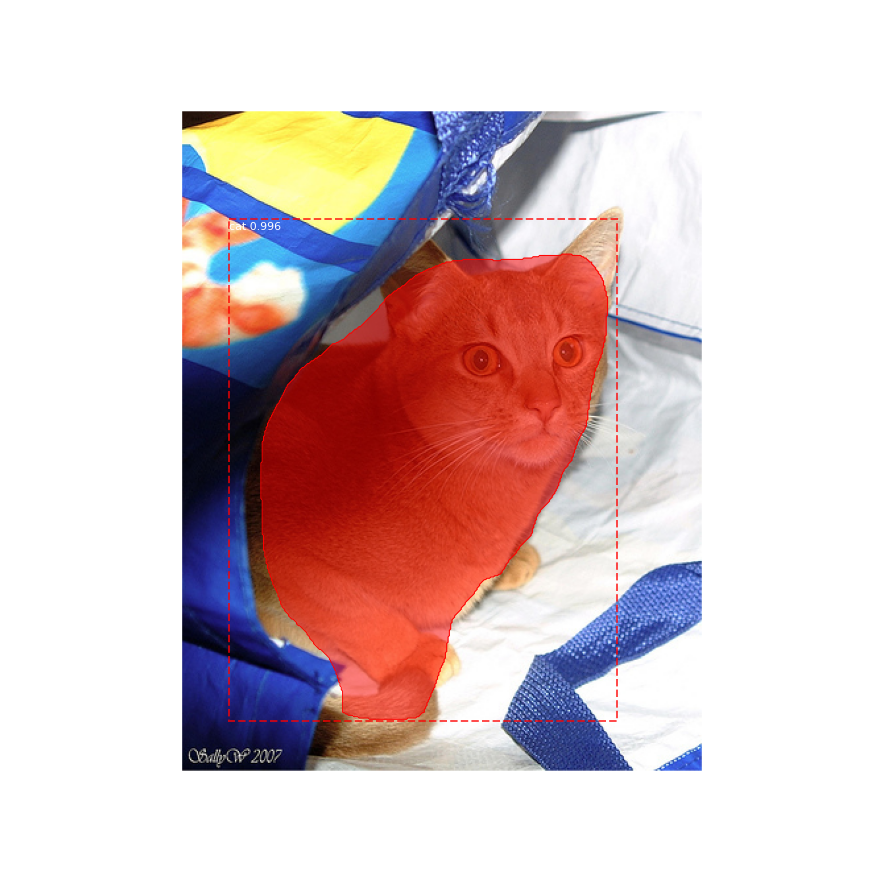

In [25]:
visualize.display_instances(dataset.load_image(0), r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])